In [4]:
from transformers import GPT2LMHeadModel

In [5]:
model_hf = GPT2LMHeadModel.from_pretrained("gpt2")
sd_hf = model_hf.state_dict()

for k,v in sd_hf.items():
    print(k,v.shape)
    
# this gives the prameters of GPT 2 models and ther shapes

"""
- There are 0-11 transformer.h layers as there are about 12 Layer in total, instead of indexing them as dict, here they are indexed as List, hence h.0, h.1, h.2.... are seperately written. 


- 

"""

transformer.wte.weight torch.Size([50257, 768])
transformer.wpe.weight torch.Size([1024, 768])
transformer.h.0.ln_1.weight torch.Size([768])
transformer.h.0.ln_1.bias torch.Size([768])
transformer.h.0.attn.c_attn.weight torch.Size([768, 2304])
transformer.h.0.attn.c_attn.bias torch.Size([2304])
transformer.h.0.attn.c_proj.weight torch.Size([768, 768])
transformer.h.0.attn.c_proj.bias torch.Size([768])
transformer.h.0.ln_2.weight torch.Size([768])
transformer.h.0.ln_2.bias torch.Size([768])
transformer.h.0.mlp.c_fc.weight torch.Size([768, 3072])
transformer.h.0.mlp.c_fc.bias torch.Size([3072])
transformer.h.0.mlp.c_proj.weight torch.Size([3072, 768])
transformer.h.0.mlp.c_proj.bias torch.Size([768])
transformer.h.1.ln_1.weight torch.Size([768])
transformer.h.1.ln_1.bias torch.Size([768])
transformer.h.1.attn.c_attn.weight torch.Size([768, 2304])
transformer.h.1.attn.c_attn.bias torch.Size([2304])
transformer.h.1.attn.c_proj.weight torch.Size([768, 768])
transformer.h.1.attn.c_proj.bias 

'\n- There are 0-11 transformer.h layers as there are about 12 Layer in total, instead of indexing them as dict, here they are indexed as List, hence h.0, h.1, h.2.... are seperately written. \n\n\n- \n\n'

tensor([-0.0188, -0.1974,  0.0040,  0.0113,  0.0638, -0.1050,  0.0369, -0.1680,
        -0.0491, -0.0565, -0.0025,  0.0135, -0.0042,  0.0151,  0.0166, -0.1381,
        -0.0063, -0.0461,  0.0267, -0.2042,  0.0135, -0.0363,  0.0193, -0.0259,
         0.0080,  0.0085, -0.0199,  0.0668,  0.0071, -0.0266])


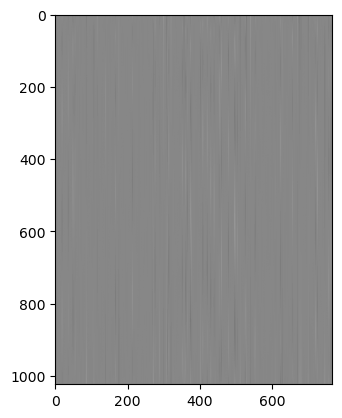

In [6]:
print(sd_hf["transformer.wpe.weight"].view(-1)[:30])

# these are weights, floats

# lets plot those wieghts

import matplotlib.pyplot as plt
%matplotlib inline

plt.imshow(sd_hf["transformer.wpe.weight"], cmap="gray")
# every row in this visualization is the absolute position ranges form [0, 1024], each rowis representation of that structure

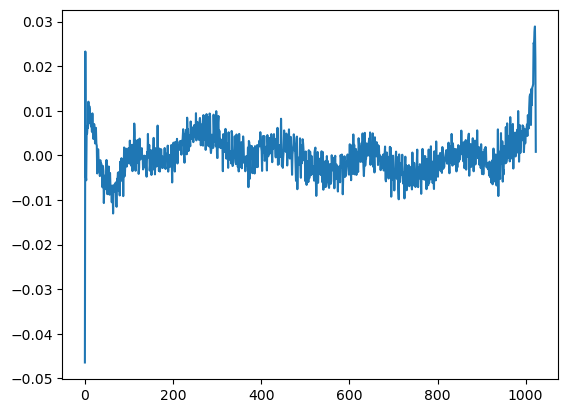

In [7]:
# plotting individul columns: 
plt.plot(sd_hf["transformer.wpe.weight"][:,150])


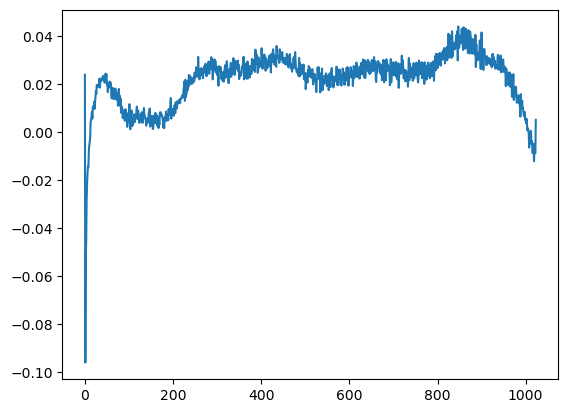

In [8]:
plt.plot(sd_hf["transformer.wpe.weight"][:,250])


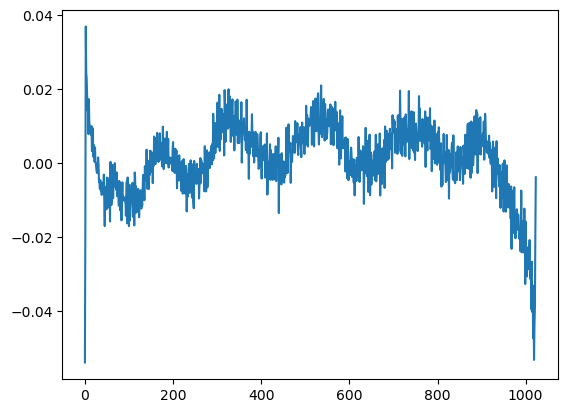

In [9]:
plt.plot(sd_hf["transformer.wpe.weight"][:,450])


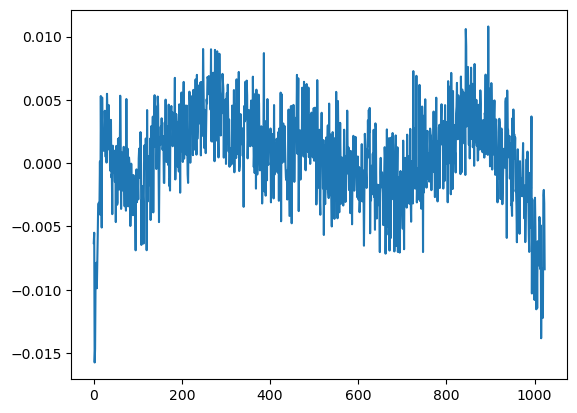

In [10]:
plt.plot(sd_hf["transformer.wpe.weight"][:,750])

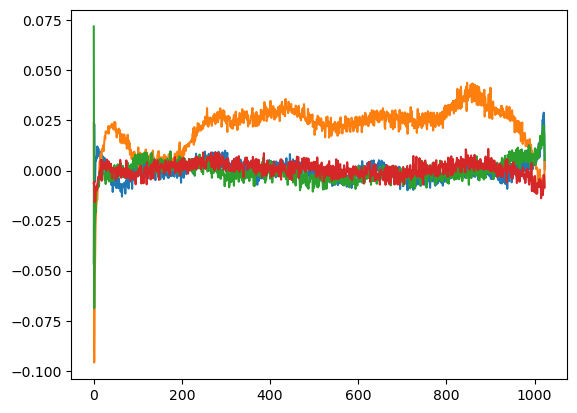

In [11]:
plt.plot(sd_hf["transformer.wpe.weight"][:,150])
plt.plot(sd_hf["transformer.wpe.weight"][:,250])
plt.plot(sd_hf["transformer.wpe.weight"][:,350])
plt.plot(sd_hf["transformer.wpe.weight"][:,750])

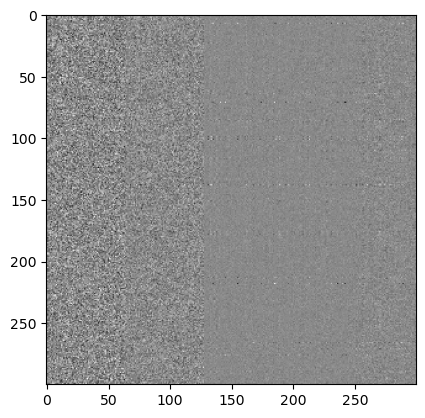

In [12]:
plt.imshow(sd_hf["transformer.h.1.attn.c_attn.weight"][:300,:300], cmap = "gray")

In [13]:
from transformers import pipeline, set_seed
generator = pipeline('text-generation', model='gpt2')
set_seed(42)
generator("Hello, I'm a language model,", max_length=30, num_return_sequences=5)

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


[{'generated_text': "Hello, I'm a language model, but what I'm really doing is making a human-readable document. There are other languages, but those are"},
 {'generated_text': "Hello, I'm a language model, not a syntax model. That's why I like it. I've done a lot of programming projects.\n"},
 {'generated_text': "Hello, I'm a language model, and I'll do it in no time!\n\nOne of the things we learned from talking to my friend"},
 {'generated_text': "Hello, I'm a language model, not a command line tool.\n\nIf my code is simple enough:\n\nif (use (string"},
 {'generated_text': "Hello, I'm a language model, I've been using Language in all my work. Just a small example, let's see a simplified example."}]

In [18]:
# let's instead sample manually
import torch
from torch.nn import functional as F

model = GPT2LMHeadModel.from_pretrained("gpt2") # 124M
model.eval()
model.to('cuda')
torch.manual_seed(42)
torch.cuda.manual_seed(42)
tokens = [15496, 11, 314, 1101, 257, 3303, 2746, 11] # "Hello, I'm a language model,"
tokens = torch.tensor(tokens, dtype=torch.long) # (8,)
tokens = tokens.unsqueeze(0).repeat(5, 1) # (5, 8)
x = tokens.to('cuda')

# generate!
while x.size(1) < 30: # max_length=30
    # forward the model to get the logits
    with torch.no_grad():
        logits = model(x)[0] # (B, T, vocab_size)
        # take the logits at the last position
        logits = logits[:, -1, :] # (B, vocab_size)
        # get the probabilities
        probs = F.softmax(logits, dim=-1)
        # do top-k sampling of 50 (huggingface pipeline default)
        # topk_probs here becomes (5, 50), topk_indices is (5, 50)
        topk_probs, topk_indices = torch.topk(probs, 50, dim=-1)
        # select a token from the top-k probabilities
        # note: multinomial does not demand the input to sum to 1
        ix = torch.multinomial(topk_probs, 1) # (B, 1)
        # gather the corresponding indices
        xcol = torch.gather(topk_indices, -1, ix) # (B, 1)
        # append to the sequence
        x = torch.cat((x, xcol), dim=1)

# print the generated text
import tiktoken
enc = tiktoken.get_encoding('gpt2')
for i in range(5):
    tokens = x[i, :30].tolist()
    decoded = enc.decode(tokens)
    print(">", decoded)

> Hello, I'm a language model, not a program.

So this morning I started studying for the interview in the lab. This was not
> Hello, I'm a language model, and one of the main things that bothers me when they create languages is how easy it becomes to create something that
> Hello, I'm a language model, and I wrote it off on the grounds that a language model would make me more fluent. But I'm not
> Hello, I'm a language model, I really like languages. I like languages because like, they're good. And the way we talk about languages
> Hello, I'm a language model, a language model I'm using for data modelling. All I did was test the results and then I wrote some


In [14]:
# tiny shakespeare dataset
!wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
with open('input.txt', 'r') as f:
    text = f.read()
data = text[:1000] # first 1,000 characters
print(data[:100])

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


--2024-11-15 19:18:16--  https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: ‘input.txt.1’

input.txt.1         100%[===================>]   1.06M  --.-KB/s    in 0.02s   

2024-11-15 19:18:17 (53.0 MB/s) - ‘input.txt.1’ saved [1115394/1115394]

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You


In [19]:
!wc input.txt


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  40000  202651 1115394 input.txt


In [ ]:
import tiktoken
enc = tiktoken.get_encoding('gpt2')
tokens = enc.encode(data)
print(tokens[:24])
"""
198 = /n - common in gpt2 encodings
"""

[5962, 22307, 25, 198, 8421, 356, 5120, 597, 2252, 11, 3285, 502, 2740, 13, 198, 198, 3237, 25, 198, 5248, 461, 11, 2740, 13]


Now we want to process these token sequences and feed them into transformers as the idx variables (index = inputs to transformer)

idx's shape = (B, T) where B is the batch size and T is the maximum token length in the batch.

we need to create a BxT tensor out of those 1D sequences of tokens 

where each row is a token sequence and each column is the index of the token in the vocabulary.

In [29]:
import torch
buf = torch.tensor(tokens[:24])
x = buf.view(4,6) # 2D arrangement of those tokens, thisis going to stakc up every 6 tokens as independent rows and it creates a batch of tokens that can be fed to transformer
print(x)
"""
Observe the output
So, lets consider 314, if the data is fed to transformer till 314, its job is to predict the next token which is 1101, here we have given the next tokens but in general, after last token transformer doesnt know what comes next so it needs to predict it using the all previous tokens. 
"""

tensor([[15496,    11,   314,  1101,   257,  3303],
        [ 2746,    11,   257,  3303,  2746,   314],
        [ 1101,  1262,   329,  1366, 38591,    13],
        [ 1439,   314,   750,   373,  1332,   262]])


'\nObserve the output\nSo, lets consider 314, if the data is fed to transformer till 314, its job is to predict the next token which is 1101, here we have given the next tokens but in general, after last token transformer doesnt know what comes next so it needs to predict it using the all previous tokens. \n'

In [ ]:
# Slight modification to the same code:
import torch
buf = torch.tensor(tokens[:24 + 1]) # loading a buffer of t "+1" token so we load a buffer of tokene (B * (T+1))
x = buf[:-1].view(4,6) 
y = buf[1:].view(4,6) # Targets for the transformer
# in y = skipping the first element, starting at index 1 not 0. 
print(x)
print(y)
# 2 tensors because, one of them is the input to the transformer and other is the labels

tensor([[15496,    11,   314,  1101,   257,  3303],
        [ 2746,    11,   257,  3303,  2746,   314],
        [ 1101,  1262,   329,  1366, 38591,    13],
        [ 1439,   314,   750,   373,  1332,   262]])
tensor([[   11,   314,  1101,   257,  3303,  2746],
        [   11,   257,  3303,  2746,   314,  1101],
        [ 1262,   329,  1366, 38591,    13,  1439],
        [  314,   750,   373,  1332,   262,  2482]])
